# Compute reduced alphabet 

In [305]:
import pandas as pd
import pyrepseq as prs
import numpy as np
import itertools
import matplotlib.pyplot as plt

## Import data

In [306]:
DATA_PATH = '/home/jhenderson/Documents/Projects/data_sets/tcr_sequences/CI_CRUK_datathon/'
#DATA_PATH = '/Users/james/Documents/Projects/data_sets/tcr_sequences/CI_CRUK_datathon/'

train = pd.read_csv(DATA_PATH + 'processed_data/train.csv')
train = train[['CDR3A', 'CDR3B', 'epitope', 'Assays']].dropna().reset_index(drop=True)
train = train[train['Assays'].str.contains('mer')]

aminoacids = 'ACDEFGHIKLMNPQRSTVWY'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/james/Documents/Projects/data_sets/tcr_sequences/CI_CRUK_datathon/processed_data/train.csv'

In [4]:
train = train[~(train['CDR3A'].str.contains('\#') | (train['CDR3A'].str.contains('\*')) | (train['CDR3A'].str.contains('X')))]

<>:1: SyntaxWarning: invalid escape sequence '\#'
<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\#'
<>:1: SyntaxWarning: invalid escape sequence '\*'
/tmp/ipykernel_959905/3944243217.py:1: SyntaxWarning: invalid escape sequence '\#'
  train = train[~(train['CDR3A'].str.contains('\#') | (train['CDR3A'].str.contains('\*')) | (train['CDR3A'].str.contains('X')))]
/tmp/ipykernel_959905/3944243217.py:1: SyntaxWarning: invalid escape sequence '\*'
  train = train[~(train['CDR3A'].str.contains('\#') | (train['CDR3A'].str.contains('\*')) | (train['CDR3A'].str.contains('X')))]


## Construct all possible reduced epitopes

In [25]:
letters = ['0', '1']
possible_reduced_epitopes = [''.join(i) for i in itertools.product(letters, repeat = 5)]
reduced_epitope_letter_counts = {epitope : [epitope.count('0'), epitope.count('1')] for epitope in possible_reduced_epitopes }

## Translation evaluation

In [32]:
def translate_df(df, translation, columns_to_translate):
    
    df = df.copy()
    translation_table = str.maketrans(translation)
    for column in columns_to_translate:
        df['translation_'+column] = df[column].apply(lambda x: x.translate(translation_table))
    return df

In [33]:
def compute_epitope_prior(translation):
    
    alphabet = list(translation.values()) 
    counts = {'0':alphabet.count('0'), '1':alphabet.count('1')}
    priors = pd.Series(index=possible_reduced_epitopes)
    for epitope in possible_reduced_epitopes:
        priors[epitope] = (counts['0']/20)**(reduced_epitope_letter_counts[epitope][0])*(counts['1']/20)**(reduced_epitope_letter_counts[epitope][1])
        
    return priors

In [76]:
def pc_conditional(df, feature, grouping, group_weights):
    
    df = df.groupby(grouping).filter(lambda x: len(x) > 1)
    conditional_pcs = df.groupby(grouping).apply(lambda x: prs.pc(x[feature]), include_groups=False)
    adjusted_group_weights = (group_weights**2)/np.sum(group_weights**2)
    
    return np.sum(adjusted_group_weights * conditional_pcs)

In [77]:
def pc_cross(df, feature, grouping, group_weights):
    
    groups = sorted(list(df.groupby(grouping)))
    pc_group = np.sum(group_weights**2)
    data = []
    for ((name1, d1)), (name2, d2) in itertools.combinations(groups, 2):
        pc_cross_group = prs.pc(d1[feature], d2[feature])
        weight = (group_weights[name1] * group_weights[name2]) / (1-pc_group)
        data.append(weight * pc_cross_group)      
    data = np.array(data)
    return np.sum(data)

In [78]:
def estimate_background_entropy(df, feature, grouping, epitope_weights):
    
    pc_within = pc_conditional(df, feature, grouping, epitope_weights)
    pc_across = pc_cross(df, feature, grouping, epitope_weights)
    pc_epitope = np.sum(epitope_weights**2)
    
    return -np.log2(pc_epitope*pc_within + (1-pc_epitope)*pc_across)

In [83]:
def evaluate_translation(translation, spc):
     
    spc = translate_df(spc, translation, ['CDR3A', 'CDR3B', 'epitope'])
    epitope_weights = compute_epitope_prior(translation)
    
    return estimate_background_entropy(spc, 'translation_CDR3A', 'translation_epitope', epitope_weights) + estimate_background_entropy(spc, 'translation_CDR3B', 'translation_epitope', epitope_weights) + np.log2(pc_conditional(spc, 'translation_CDR3A', 'translation_epitope', epitope_weights)) + np.log2(pc_conditional(spc, 'translation_CDR3B', 'translation_epitope', epitope_weights))

In [84]:
def make_translation_from_list(aa_to_be_one):
    
    return {aa: '1' if aa in aa_to_be_one else '0' for aa in aminoacids}

In [85]:
def greedy_algorithm(df):
    
    best_amino_acids_to_be_one = []
    best_score = -np.inf
    for i in range(20):
        best_amino_acid_to_be_one = ""
        best_local_score = -np.inf
        for aa in aminoacids:
            if aa not in best_amino_acids_to_be_one:
                list_to_try = best_amino_acids_to_be_one.copy()
                list_to_try.append(aa)
                translation = make_translation_from_list(list_to_try)
                score = evaluate_translation(translation, df)
                
                if score > best_local_score:
                    best_amino_acid_to_be_one = aa
                    best_local_score = score
        
        if best_local_score <= best_score:
            print("Locally optimal set found")
            return best_amino_acids_to_be_one, best_score
        
        else:
            print(f"Improvement found, new score: {best_local_score:.1f} bits")
            best_score = best_local_score
            best_amino_acids_to_be_one.append(best_amino_acid_to_be_one)
            
    return best_amino_acids_to_be_one, best_score

## Training the representation

In [86]:
best, score = greedy_algorithm(train)

Improvement found, new score: 0.7 bits
Improvement found, new score: 1.2 bits
Improvement found, new score: 1.7 bits
Improvement found, new score: 2.1 bits
Improvement found, new score: 2.5 bits
Improvement found, new score: 2.7 bits
Improvement found, new score: 2.8 bits
Locally optimal set found


In [124]:
best, [aa for aa in aminoacids if aa not in best], score

(['G', 'R', 'A', 'S', 'I', 'P', 'C'],
 ['D', 'E', 'F', 'H', 'K', 'L', 'M', 'N', 'Q', 'T', 'V', 'W', 'Y'],
 np.float64(2.7867331737098366))

In [132]:
best_translation = make_translation_from_list(best)
translated_df = translate_df(train, best_translation, ['CDR3A', 'CDR3B', 'epitope'])


In [94]:
prs.renyi2_entropy(translated_df, 'translation_CDR3A') + prs.renyi2_entropy(translated_df, 'translation_CDR3B')

np.float64(9.369524676509512)

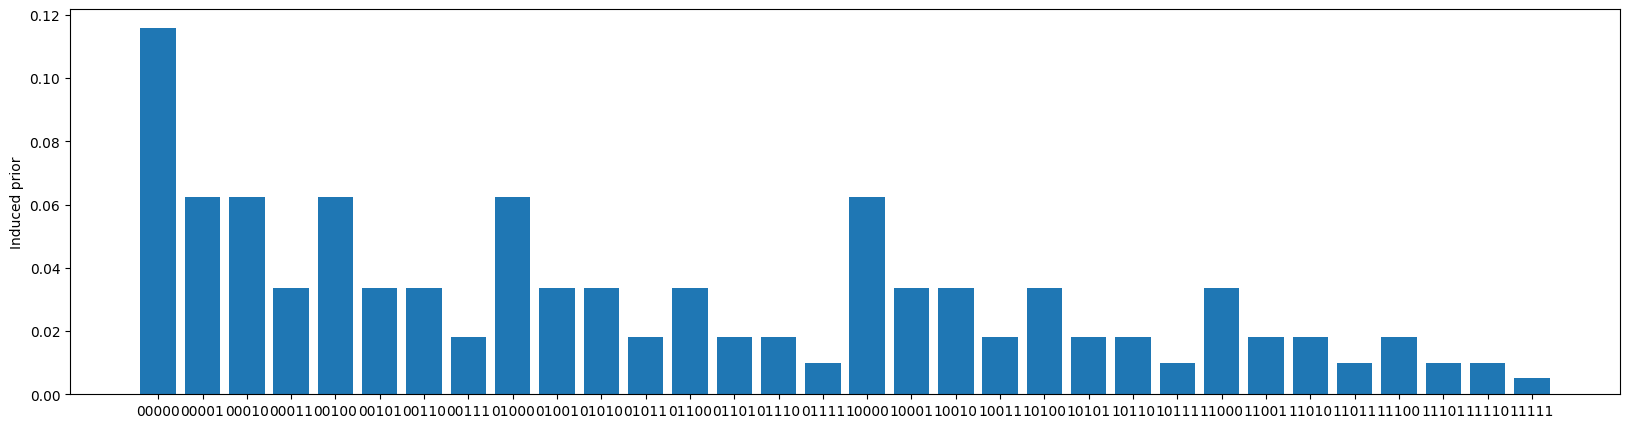

In [139]:
fig, ax = plt.subplots(figsize = (20, 5))
ax.bar(compute_epitope_prior(best_translation).index, compute_epitope_prior(best_translation))
ax.set_ylabel('Induced prior');

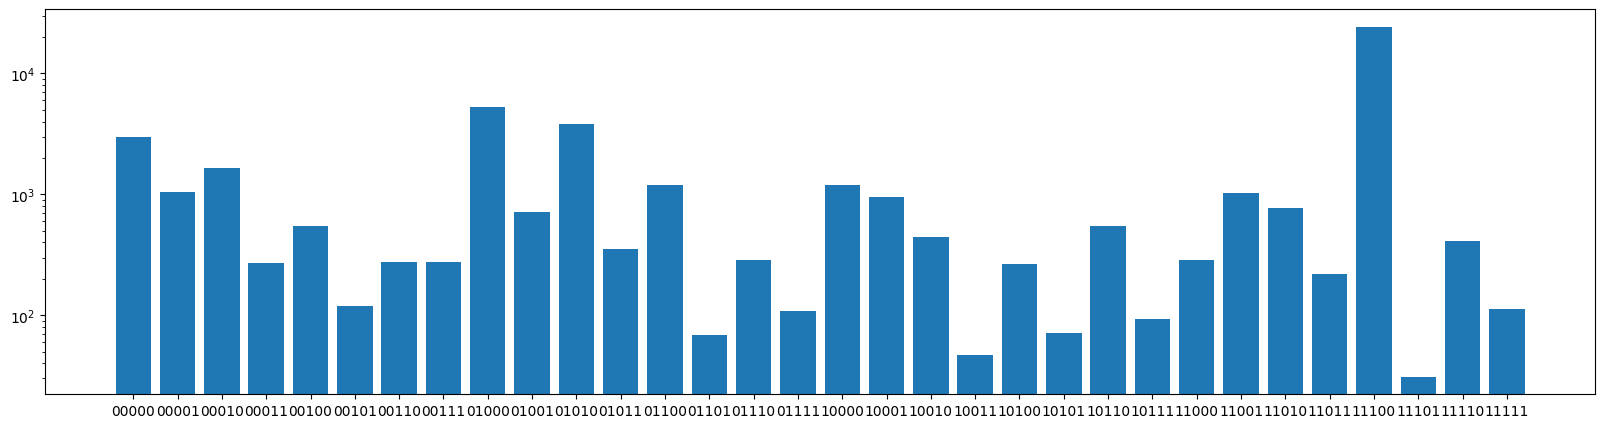

In [118]:
unique_epitopes, counts_epitopes = np.unique(translated_df['translation_epitope'], return_counts=True)
fig, ax = plt.subplots(figsize = (20, 5))
ax.bar(unique_epitopes,counts_epitopes)
ax.set_yscale('log');

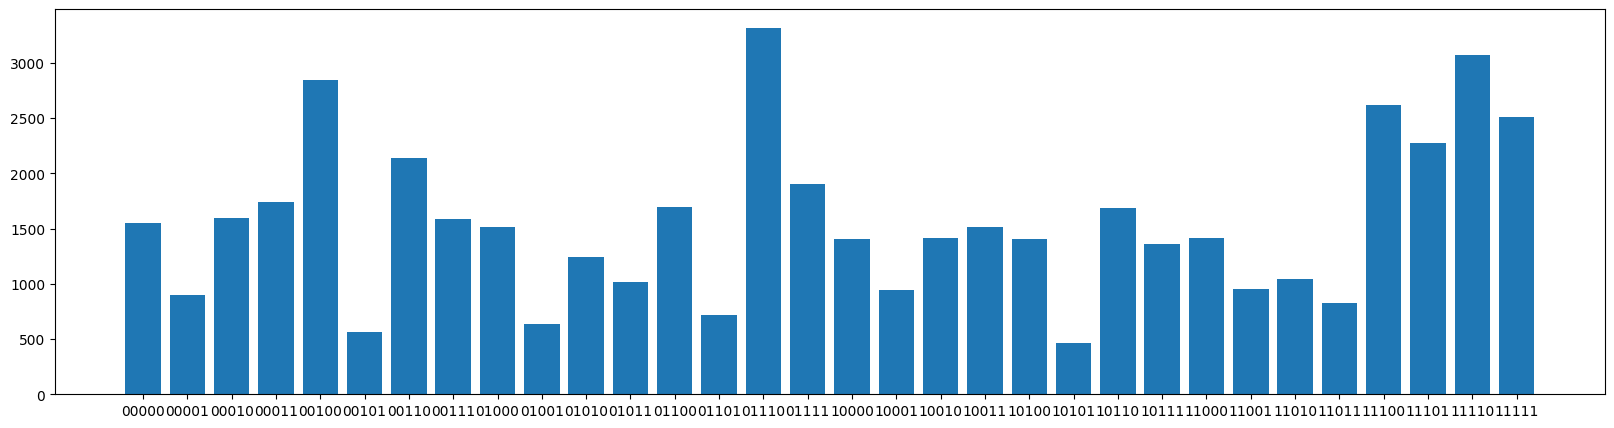

In [123]:
unique_alphas, counts_alphas = np.unique(translated_df['translation_CDR3A'], return_counts=True)
fig, ax = plt.subplots(figsize = (20, 5))
ax.bar(unique_alphas,counts_alphas);

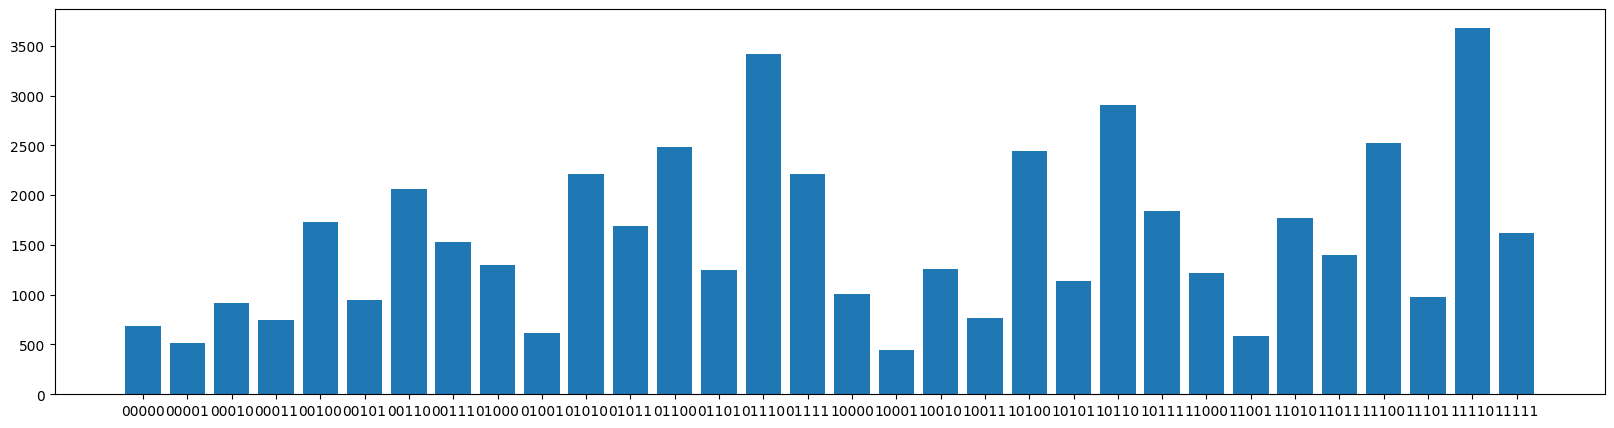

In [122]:
unique_betas, counts_betas = np.unique(translated_df['translation_CDR3B'], return_counts=True)
fig, ax = plt.subplots(figsize = (20, 5))
ax.bar(unique_betas,counts_betas);

## Validation on OLGA

In [125]:
back = pd.read_csv(DATA_PATH + 'raw_data/olga_preprocessed.csv')

In [126]:
def trim_sequences(df):
    
    df = df.copy()
    
    df.loc[:, 'CDR3A_length'] = df['CDR3A'].str.len().astype('Int64')
    df.loc[:, 'CDR3B_length'] = df['CDR3B'].str.len().astype('Int64')

    df = df[
        (df['CDR3A_length'].isna()) | 
        (df['CDR3A_length'] >= 9) & 
        (df['CDR3A_length'] <= 18)
    ]

    df = df[
        (df['CDR3B_length'].isna()) | 
        (df['CDR3B_length'] >= 11) & 
        (df['CDR3B_length'] <= 18)
    ]
    
    return df

def get_middle_five_left(aa_string):
    if pd.isna(aa_string):  # Check for NaN/null values
        return aa_string
    length = len(aa_string)
    
    if( length % 2 == 0 ):
            mid = length // 2 # integer division will ensure that doesnt matter if even or odd - it is floor so always rounds down
            start = mid - 3
            end = mid + 2
    else:
            mid = length // 2
            start = mid - 2
            end = mid + 3

    return aa_string[start:end]


def get_middle_five_right(aa_string):
    if pd.isna(aa_string):  # Check for NaN/null values
        return aa_string
    length = len(aa_string)
    
    if( length % 2 == 0 ):
            mid = length // 2 # integer division will ensure that doesnt matter if even or odd - it is floor so always rounds down
            start = mid - 2
            end = mid + 3
    else:
            mid = length // 2
            start = mid - 2
            end = mid + 3

    return aa_string[start:end]

back = trim_sequences(back)
back['CDR3A'] = back['CDR3A'].apply(get_middle_five_left)
back['CDR3B'] = back['CDR3B'].apply(get_middle_five_left)

In [130]:
back = translate_df(back, best_translation, ['CDR3A', 'CDR3B'])

In [131]:
prs.renyi2_entropy(back, 'translation_CDR3A') + prs.renyi2_entropy(back, 'translation_CDR3B')

np.float64(9.529198029316854)

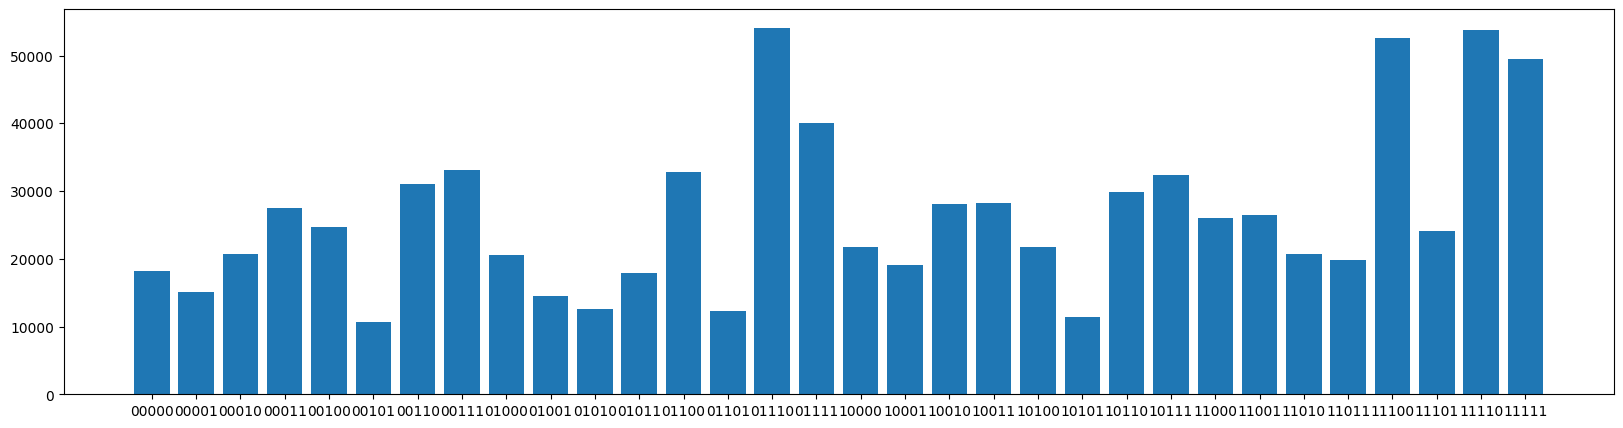

In [140]:
unique_alphas, counts_alphas = np.unique(back['translation_CDR3A'], return_counts=True)
fig, ax = plt.subplots(figsize = (20, 5))
ax.bar(unique_alphas,counts_alphas);

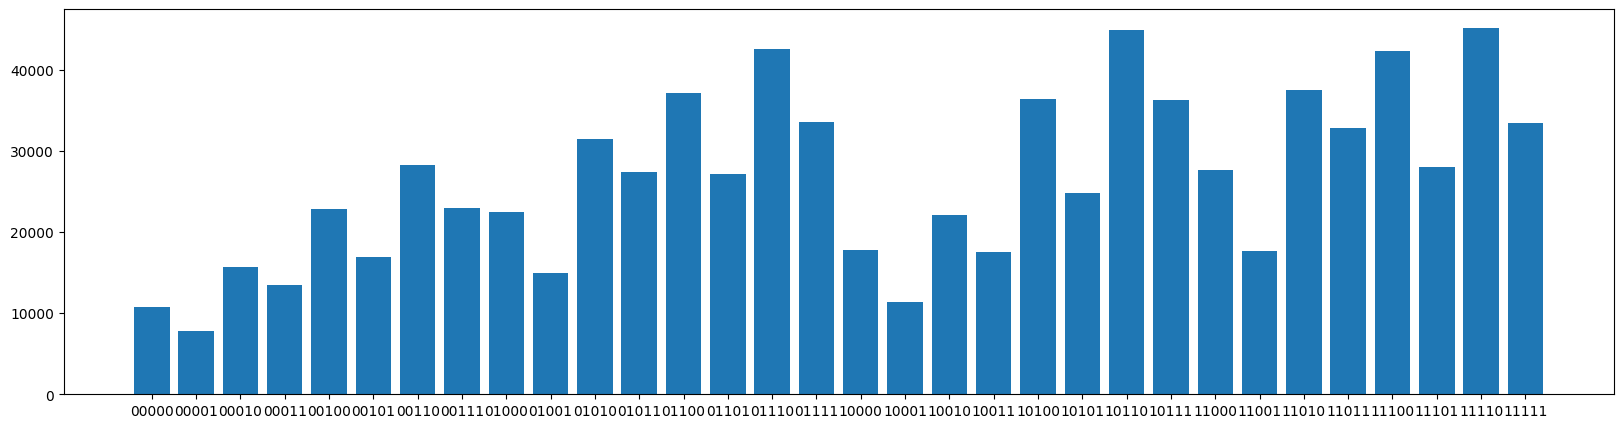

In [141]:
unique_betas, counts_betas = np.unique(back['translation_CDR3B'], return_counts=True)
fig, ax = plt.subplots(figsize = (20, 5))
ax.bar(unique_betas, counts_betas);

## PCA

In [229]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

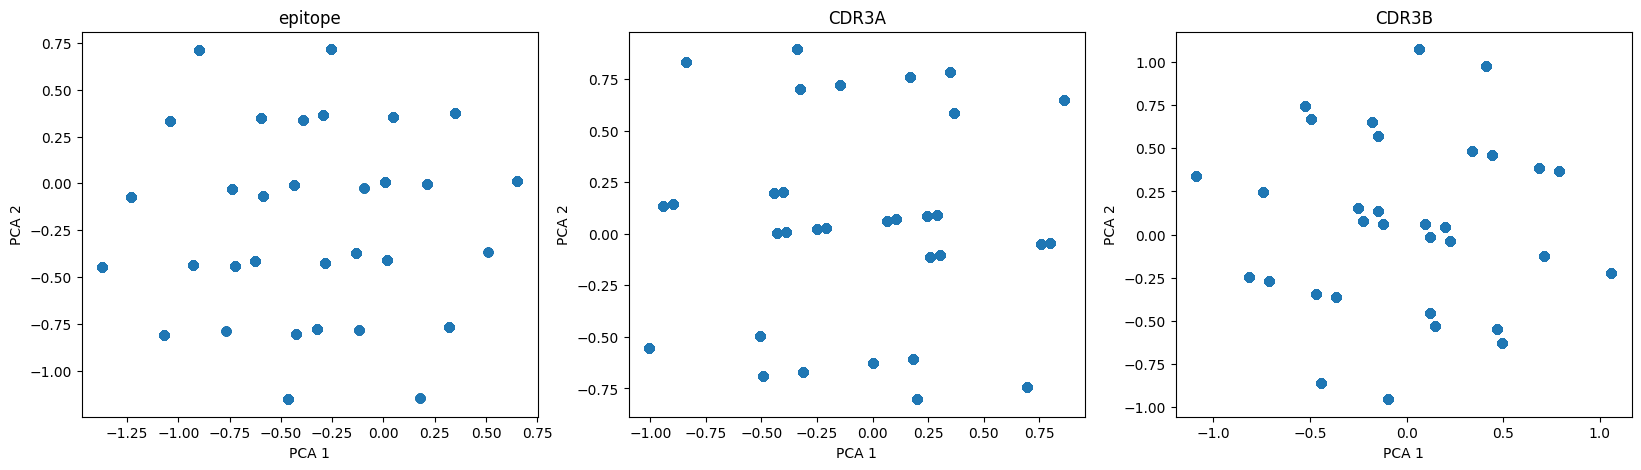

In [237]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

features = ['epitope', 'CDR3A', 'CDR3B']
for i, feature in enumerate(features):
    X = np.stack(translated_df[f'translation_{feature}'].apply(lambda x: np.array(list(x)).astype(int)).values) 
    X_r = pca.fit(X).transform(X)
    ax[i].set_title(f"{feature}")
    ax[i].set_xlabel('PCA 1')
    ax[i].set_ylabel('PCA 2')
    ax[i].scatter(X_r[:, 0], X_r[:, 1]);

## Save the data